- Note: Please do not rerun the code since training is time-consuming;
- Code is tested on tiny-debug-cluster-gpu. 
## Load Libraries

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

import random
import os
import cv2
import glob 

# PIL adds image processing capabilities to your Python interpreter.
import PIL
from PIL import Image, ImageOps

# Shutil module offers high-level operation on a file like a copy, create, and remote operation on the file.
import shutil

# skimage is a collection of algorithms for image processing and computer vision.
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize

# NEURAL IMAGING
import nilearn as nl
import nibabel as nib # access a multitude of neuroimaging data formats

# ML Libraries
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing

# make numpy printouts easier to read
np.set_printoptions(precision = 3, suppress = True)

import warnings
warnings.filterwarnings('ignore')

In [0]:
# dataset path
train_data = "/dbfs/FileStore/tables/BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"
valid_data = "/dbfs/FileStore/tables/BraTS2020/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/"

## Data Visualization
%md
All BraTS multimodal scans are available as NIfTI files (.nii.gz) and describe a) native (T1) and b) post-contrast T1-weighted (T1Gd), c) T2-weighted (T2), and d) T2 Fluid Attenuated Inversion Recovery (T2-FLAIR) volumes, and were acquired with different clinical protocols and various scanners from multiple (n=19) institutions. The data is collected from this [link](https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation). All the imaging datasets have been segmented manually, by one to four raters, following the same annotation protocol, and their annotations were approved by experienced neuro-radiologists. Annotations comprise the GD-enhancing tumor (ET — label 4), the peritumoral edema (ED — label 2), and the necrotic and non-enhancing tumor core (NCR/NET — label 1), as described both in the BraTS 2012-2013 TMI paper and in the latest BraTS summarizing paper. The provided data are distributed after their pre-processing, i.e., co-registered to the same anatomical template, interpolated to the same resolution (1 mm^3) and skull-stripped.

Out[5]: Text(0.5, 1.0, 'Mask')

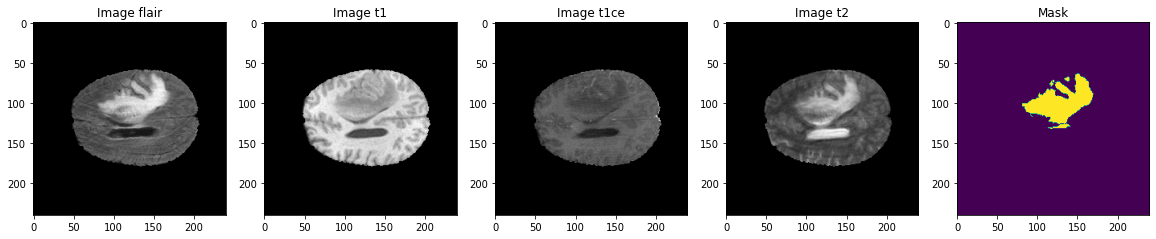

In [0]:
test_image_flair = nib.load(train_data + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_t1 = nib.load(train_data + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1ce = nib.load(train_data + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2 = nib.load(train_data + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_mask = nib.load(train_data + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize = (20, 10))
slice_w = 25

# FLAIR
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')

# T1
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')

# T1CE
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')

# T2
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')

# MASK
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

Out[6]: <matplotlib.image.AxesImage at 0x7f9747874d90>

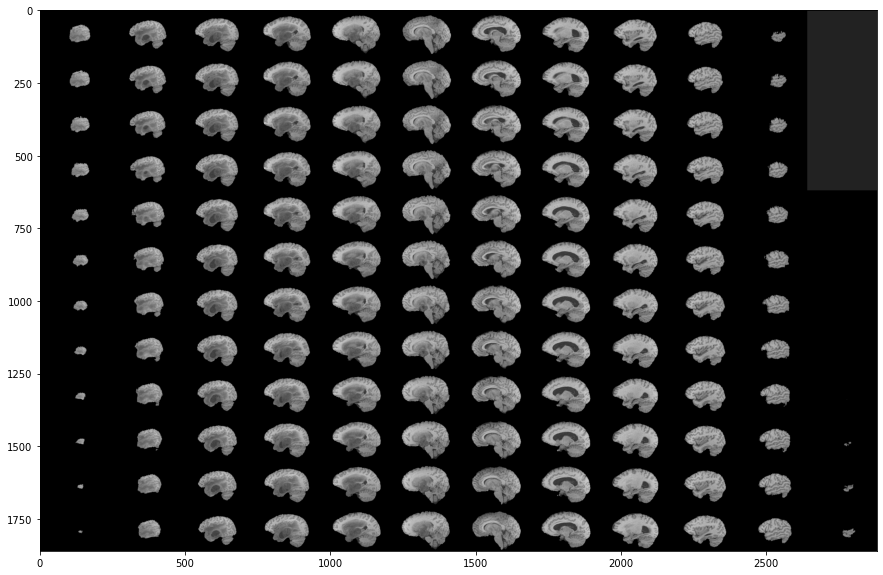

In [0]:
# skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15, 15))
ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize = True), cmap = 'gray')

Out[7]: <matplotlib.image.AxesImage at 0x7f97478b8940>

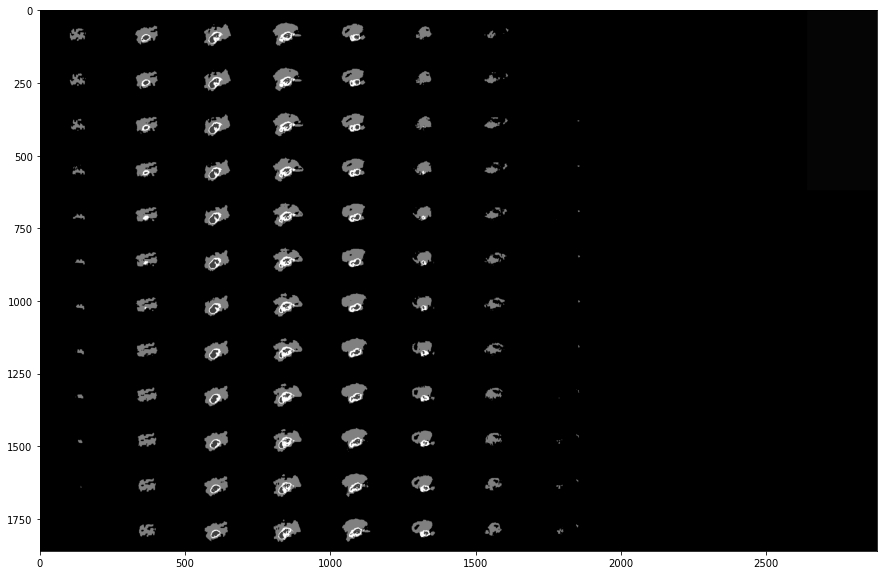

In [0]:
# skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15, 15))
ax1.imshow(rotate(montage(test_mask[50:-50,:,:]), 90, resize = True), cmap = 'gray')

## Data Preparation

No handles with labels found to put in legend.


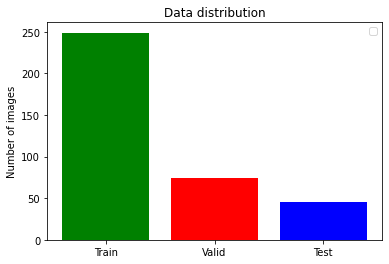

In [0]:
# list of directories
train_val_directories = [f.path for f in os.scandir(train_data) if f.is_dir()]

# remove BraTS20_Training_355 since it has ill formatted name for seg.nii file
train_val_directories.remove(train_data + 'BraTS20_Training_355')

# function to convert list of paths into IDs
def pathListIntoIDs(dirList):
  x = []
  for i in range(0, len(dirList)):
    x.append(dirList[i][dirList[i].rfind('/')+1:])
  return x

ids = pathListIntoIDs(train_val_directories)

# split ids into train+test and validation
train_test_ids, val_ids = train_test_split(ids, test_size = 0.2, random_state = 42)
# split train+test into train and test                                           
train_ids, test_ids = train_test_split(train_test_ids, test_size = 0.15, random_state = 42)

# function to display data distribution
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()
    
showDataLayout()

In [0]:
# define segmentation areas
SEGMENT_CLASSES = {
    0 : 'NOT TUMOR',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING TUMOR CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}
 
# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 # first slice of volume that we will include
IMG_SIZE = 128

# override keras sequence DataGenerator class
class DataGenerator(keras.utils.Sequence):
    # generates data for Keras
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        # Initialization
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        # denotes the number of batches per epoch
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        # generate one batch of data

        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        # updates indexes after each epoch
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))

        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(train_data, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            ce = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
                    
        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        #print("X size = {};\nY size = {}".format(X.shape, Y.shape))
        return X/np.max(X), Y

In [0]:
# function to take in data and return a dictionary with client names as keys and values as data shards
def create_client(data, num_clients, initial = 'client'):
  # create a list of client names
  client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

  # size of data shard
  # size = len(data)//num_clients
  # create data shard for each client for i in [200, 40, 9]
  shards = [data[0:200], data[200:240], data[240:249]]
  print(len(data),len(shards), len(client_names))
  print(len(shards[0]),len(shards[1]),len(shards[2]))
  print(shards[0][0])

  # number of clients must equal number of shards
  assert(len(shards) == len(client_names))

  return {client_names[i] : shards[i] for i in range(len(client_names))} 

def weight_scaling_factor(data):
    return len(data)/len(train_ids)


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final



def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad


# function to evaluate the model on test data and print the current round and metrics
def evaluate_model(data, model, round): 
  test_generator = DataGenerator(data)
  results = model.evaluate(test_generator, batch_size = batch_size, verbose = 1)
  loss, accuracy = results[0], results[1]*100
  print(f'round: {round} | loss: {loss} | accuracy: {accuracy:.2f}%')

## Train on the smallest client

In [0]:
# create clients
clients = create_client(train_ids,3)
valid_generator = DataGenerator(val_ids)

249 3 3
200 40 9
BraTS20_Training_124


In [0]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [0]:
# Losses
from keras_unet_collection import losses
# losses.dice, losses.dice_coef

# dice loss as defined above for 4 classes
def dice_coef_class(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss

# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(y_true[:,:,:,1]) + K.sum(y_pred[:,:,:,1]) + epsilon) # I dont like squre

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(y_true[:,:,:,2]) + K.sum(y_pred[:,:,:,2]) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(y_true[:,:,:,3]) + K.sum(y_pred[:,:,:,3]) + epsilon)

# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [0]:
# U-NET
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)
    
    return Model(inputs = inputs, outputs = conv10)


In [0]:
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

save_path = "/dbfs/FileStore/tables/BraTS2020/"
# add callback for training process
csv_logger = CSVLogger(f'{save_path}training_single_client.log', separator=',', append=False)

checkpoint_filepath = f'{save_path}checkpoint_signle_client'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

callbacks = [
      model_checkpoint_callback,
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
      csv_logger
    ]


In [0]:
# TRAIN MODEL
BATCH_SIZE = 1

K.clear_session()
with strategy.scope():
    model = build_unet(input_layer, 'he_normal', 0.2)
    model.compile(
        loss = "categorical_crossentropy",
        optimizer = keras.optimizers.Adam(learning_rate = 0.001),
        metrics = ['accuracy', tf.keras.metrics.MeanIoU(num_classes = 4), dice_coef_class, losses.dice, losses.dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing]
    )

training_generator = DataGenerator(clients[list(clients.keys())[2]], batch_size = BATCH_SIZE * strategy.num_replicas_in_sync)    
history =  model.fit(training_generator,
                    epochs=30,
                    steps_per_epoch=len(training_generator),
                    callbacks= callbacks,
#                     validation_data = valid_generator
                    )  

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Epoch 1/30
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tens

In [0]:
# evaluation
save_path = "/dbfs/FileStore/tables/BraTS2020/"

# load training history
history = pd.read_csv(f"{save_path}training_single_client.log", sep = ',', engine = 'python')

acc = history['accuracy']

epoch = range(len(acc))

loss = history['loss']

dice_class = history['dice_coef_class']

dice = history['dice_coef']

mean_iou = history['mean_io_u']

# visualize the training process
f, ax = plt.subplots(1, 5, figsize = (25, 8))

# ACCURACY
ax[0].plot(epoch, acc, 'b', label = 'Training Accuracy')
ax[0].legend()

# LOSS
ax[1].plot(epoch, loss, 'b', label = 'Training Loss')
ax[1].legend()

# CLASS DICE COEFFICIENT
ax[2].plot(epoch, dice_class, 'b', label = 'Training Class Dice Coefficient')
ax[2].legend()

# DICE COEFFICIENT
ax[3].plot(epoch, dice, 'b', label = 'Training Dice Coefficient')
ax[3].legend()

# Mean IoU
ax[4].plot(epoch, mean_iou, 'b', label = 'Training MeanIoU')
ax[4].legend()

plt.show()

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-254864213267802> in <module> 
 3 
 4 # load training history 
 ----> 5 history = pd . read_csv ( f"{save_path}training_single_client.log" , sep = ',' , engine = 'python' ) 
 6 
 7 acc = history [ 'accuracy' ] 

 NameError : name 'pd' is not defined

## Train on the biggest client

In [0]:
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

save_path = "/dbfs/FileStore/tables/BraTS2020/"
# add callback for training process
csv_logger = CSVLogger(f'{save_path}training_single_client_1.log', separator=',', append=False)

checkpoint_filepath = f'{save_path}checkpoint_signle_client_1'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

callbacks = [
      model_checkpoint_callback,
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
      csv_logger
    ]


In [0]:
# TRAIN MODEL
BATCH_SIZE = 1

K.clear_session()
with strategy.scope():
    model = build_unet(input_layer, 'he_normal', 0.2)
    model.compile(
        loss = "categorical_crossentropy",
        optimizer = keras.optimizers.Adam(learning_rate = 0.001),
        metrics = ['accuracy', tf.keras.metrics.MeanIoU(num_classes = 4), dice_coef_class, losses.dice, losses.dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing]
    )

training_generator = DataGenerator(clients[list(clients.keys())[0]], batch_size = BATCH_SIZE * strategy.num_replicas_in_sync)    
history =  model.fit(training_generator,
                    epochs=30,
                    steps_per_epoch=len(training_generator),
                    callbacks= callbacks,
#                     validation_data = valid_generator
                    )  

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Epoch 1/30
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tens

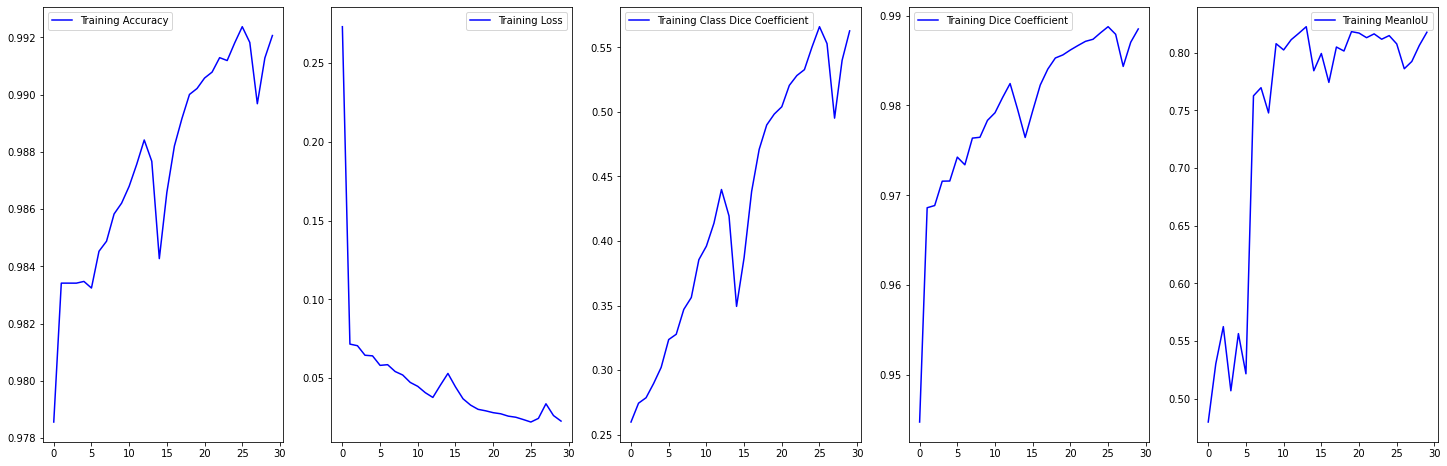

In [0]:
# evaluation
save_path = "/dbfs/FileStore/tables/BraTS2020/"

# load training history
history = pd.read_csv(f"{save_path}training_single_client_1.log", sep = ',', engine = 'python')

acc = history['accuracy']

epoch = range(len(acc))

loss = history['loss']

dice_class = history['dice_coef_class']

dice = history['dice_coef']

mean_iou = history['mean_io_u']

# visualize the training process
f, ax = plt.subplots(1, 5, figsize = (25, 8))

# ACCURACY
ax[0].plot(epoch, acc, 'b', label = 'Training Accuracy')
ax[0].legend()

# LOSS
ax[1].plot(epoch, loss, 'b', label = 'Training Loss')
ax[1].legend()

# CLASS DICE COEFFICIENT
ax[2].plot(epoch, dice_class, 'b', label = 'Training Class Dice Coefficient')
ax[2].legend()

# DICE COEFFICIENT
ax[3].plot(epoch, dice, 'b', label = 'Training Dice Coefficient')
ax[3].legend()

# Mean IoU
ax[4].plot(epoch, mean_iou, 'b', label = 'Training MeanIoU')
ax[4].legend()

plt.show()

## Train Federated Model

In [0]:
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

save_path = "/dbfs/FileStore/tables/BraTS2020/"
# add callback for training process
csv_logger = CSVLogger(f'{save_path}training_fl.log', separator=',', append=False)

checkpoint_filepath = f'{save_path}checkpoint_fl'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

callbacks = [
      model_checkpoint_callback,
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
      csv_logger
    ]

In [0]:
def evaluate_model(data, model): 
    test_generator = DataGenerator(data)
    results = model.evaluate(test_generator, batch_size = 32, verbose = 1)
    for i in range(len(results)):
        print("Metric_{}={}".format(i, results[i]))
    return results

In [0]:
ROUNDS = 5
SELECTED_EACH_ROUND = 1
BATCH_SIZE = 1
EPOCHS_CLIENT = 10

# initialize global model
K.clear_session()
with strategy.scope():
  global_model = build_unet(input_layer, 'he_normal', 0.2)
  global_model.compile(
        loss = "categorical_crossentropy",
        optimizer = keras.optimizers.Adam(learning_rate = 0.001),
        metrics = ['accuracy', tf.keras.metrics.MeanIoU(num_classes = 4), dice_coef_class, losses.dice, losses.dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing])

print("Begin Training")
# commence global training loop
for round in range(1, ROUNDS+1):
  print(f'\nRound: {round}')

  # get global model's weights
  global_weights = global_model.get_weights()

  # initial list to collect local model weights after scaling
  scaled_local_weight_list = list()
    
  # get client names
  client_names= list(clients.keys())
  random.shuffle(client_names)

  count = 1
  results = []
#   results.append(evaluate_model(val_ids, global_model))
  results.append(evaluate_model(clients[list(clients.keys())[2]], global_model))
  # loop through each client and create new local model
  for client in client_names[0:SELECTED_EACH_ROUND]:   
    print(f'Client {count}')
    with strategy.scope():
      local_model = build_unet(input_layer, 'he_normal', 0.2)
      local_model.compile(
        loss = "categorical_crossentropy",
        optimizer = keras.optimizers.Adam(learning_rate = 0.001),
        metrics = ['accuracy', tf.keras.metrics.MeanIoU(num_classes = 4), dice_coef_class, losses.dice, losses.dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing])
    
    #set local model weight to the weight of the global model
    local_model.set_weights(global_weights)

    # get client data and pass it through a data generator
    data = DataGenerator(clients[client], batch_size = BATCH_SIZE * trategy.num_replicas_in_sync )
    
    # fit local model with client's data
    local_model.fit(data, epochs=EPOCHS_CLIENT, steps_per_epoch = len(data), verbose = 1) #callbacks = callbacks, validation_data = valid_generator)

    # scale the model weights and add to list
    scaling_factor = weight_scaling_factor(data)
    print(f'scaling_factor = {scaling_factor}')
    scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
    
    # not adding scaling
    scaled_local_weight_list.append(local_model.get_weights()) # Here should be scaled_local_weight_list.append(scaled_weights)??
    # scaled_local_weight_list.append(scaled_weights)

    # clear session to free memory after each communication round
    K.clear_session()

    count += 1

  #to get the average over all the local model, we simply take the sum of the scaled weights
  print('len of scaled_local_weight_list = {}'.format(len(scaled_local_weight_list)))
  average_weights = sum_scaled_weights(scaled_local_weight_list)
      
  #update global model 
  global_model.set_weights(average_weights)

print('\nTraining Done!')

Begin Training

Round: 1
9/9 [==============================] - 16s 1s/step - loss: 1.4014 - accuracy: 0.0037 - mean_io_u: 0.3756 - dice_coef_class: 0.1053 - dice: 0.7535 - dice_coef: 0.2465 - precision: 0.0039 - sensitivity: 1.0173e-06 - specificity: 0.9996 - dice_coef_necrotic: 0.0083 - dice_coef_edema: 0.0116 - dice_coef_enhancing: 0.0064
Metric_0=1.4013910293579102
Metric_1=0.0036635336000472307
Metric_2=0.375579833984375
Metric_3=0.1052529513835907
Metric_4=0.7534736394882202
Metric_5=0.2465263456106186
Metric_6=0.0038940811064094305
Metric_7=1.0173283726544469e-06
Metric_8=0.9995620250701904
Metric_9=0.008261465467512608
Metric_10=0.011609210632741451
Metric_11=0.006393729709088802
Client 1
Epoch 1/10
30/40 [=====================>........] - ETA: 14s - loss: 0.3704 - accuracy: 0.9162 - mean_io_u_1: 0.4354 - dice_coef_class: 0.2367 - dice: 0.1503 - dice_coef: 0.8497 - precision: 0

*** WARNING: max output size exceeded, skipping output. ***

9/9 [==============================] - 

## Discussion
This experiment is a simulation experiment, which simulates federated learning on a machine and implements the Federated averaging algorithm. 

In this project, we investigate the unbalanced scenario of federated learning in which different clients have access to different amounts of data. A total of three clients are set up with significantly different amounts of data, e.g., 400 vs 40 vs 9. First, we tested the same model (a basic U-Net) on one client with nine training data and received a 0.36 DICE score (dice_coef_class). Then we tested if this client would benefit from federated learning. As a result, the DICE score is around 0.63, which represents a 0.3 improvement over 0.36.

Areas for further improvement:
- Model: Only a basic U-Net was investigated. In the [report](https://github.com/avocadopelvis/BTP/blob/main/report/BTP-REPORT.pdf), it is also suggested that the performance of federated learning would benefit from more advanced U-Nets;
- Modality: Different clients might have different modalities that we could simulate in the further.
- Hyperparameters: There are four main hyperparameters in federated learning: the round of federated learning procedure (ROUNDS); the selected client in each round (SELECTED_EACH_ROUND); the batch size of local training for a single client (BATCH_SIZE); the epoch number of local training for a single client (EPOCHS_CLIENT). In this project, we only present the result using a single setting: ROUNDS = 5, SELECTED_EACH_ROUND = 1, BATCH_SIZE = 1, and EPOCHS_CLIENT = 10. We have also tested other settings using another machine, but the results don't provide more information, so we chose only to present this one.
- Other options for implementing federated learning: We also believe that investigating more options for implementing federated learning will be beneficial.  We found the following other options to be of interest:  [Databricks+PyGitHub](https://www.researchgate.net/publication/348317365_Cloud-Based_Federated_Learning_Implementation_Across_Medical_Centers); [TensorFlowFederated(TFF)](https://medium.com/leadkaro/tensorflow-federated-tff-collaborative-machine-learning-without-centralized-training-data-da9218a36fc1); [Flower(PyTorch based)](https://flower.dev/docs/example-pytorch-from-centralized-to-federated.html); MONAI+NVIDIA: [link1](https://developer.nvidia.com/blog/clara-train-4-0-upgrades-to-monai-and-supports-fl-with-homomorphic-encryption/), [link2](https://docs.monai.io/en/stable/fl.html); [Ray(Pytorch)](https://www.ray.io/).